In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
params = {
    'total': 10,
    'minSelect': 1,
    'maxSelect': 9,
    'groups': 2,
    'labels': ['Frauen','Männer'],
    'colors': ['pink','teal'],
    'minOffset': -20, 
    'maxOffset': 22,
    'offsetSteps': 10,
    'clusters': 10,
}

qualifications = [
    [76],
    [86,67],
    [91,76,65],
    [94,80,72,63],
    [96,83,76,69,62],
    [98,86,79,73,68,61],
    [100,87,81,76,71,67,60],
    [100,89,83,78,74,70,66,60],
    [100,91,84,80,76,72,69,65,59],
    [100,92,86,81,77,74,71,68,64,59]
    ]

In [3]:
questions = []
questionNo = 0

# select different numbers of personas
for sel in range(params['minSelect'], params['maxSelect'] + 1):
    # all groups get to be majority
    for maj in range(params['groups']):
        # all ratios from 1:9 to 5:5
        for ratio in range(1, int(params['total']//2) + 1):
            # qualification offsets for minority
            for qualOffset in range(params['minOffset'], params['maxOffset'], params['offsetSteps']):
                # only the possible selections
                for selRatio in range(max(0, sel - (params['total'] - ratio)), min(ratio, sel) + 1):
                    
                    if (params['total']//2 == ratio):
                        # skip selecting duplicates for 5:5 groups when there's no offset
                        if(selRatio > sel/2 and qualOffset == 0): continue
                        # skip selection of 1:1, 2:2, 3:3 and 4:4 once for 5:5 groups
                        if(selRatio == sel/2 and maj == 1): continue
                    
                    question = {
                        'personas': [],
                        'questionType': 'selection',
                        'showScores': True,
                        'groupNames': [],
                        'colors': [],
                        'number': questionNo,
                        'minSize': ratio,
                        'majSize': params['total'] - ratio,
                    }
                    
                    question['groupNames'].append(params['labels'][maj])
                    question['groupNames'].append(params['labels'][(maj+1)%2])
                    question['colors'].append(params['colors'][maj])
                    question['colors'].append(params['colors'][(maj+1)%2])
                    if(maj): question['majLabel'] = 'female'
                    else: question['majLabel'] = 'male'
                    
                    for j in range(ratio): # minority personas
                        persona = {
                            'group': 0,
                            # minority qualification with offset
                            'qualification': max(min(qualifications[ratio - 1][j] + qualOffset, 100), 50),
                            'selected': j < selRatio, # select the best of the minority
                            'number': j,
                            'shouldBeSelected': False
                        }
                        question['personas'].append(persona)
                    
                    for j in range(params['total'] - ratio): # majority personas
                        persona = {
                            'group': 1,
                            'qualification': qualifications[params['total'] - ratio - 1][j],
                            'selected': j < (sel - selRatio), # select the best of the majority
                            'number': j + ratio,
                            'shouldBeSelected': False
                        }
                        question['personas'].append(persona)
                    
                    # sort by qualification
                    question['personas'].sort(key=lambda persona: persona['qualification'], reverse=True)
                    # find the ones that should be selected
                    for j in range(sel):
                        question['personas'][j]['shouldBeSelected'] = True
                    # find alpa+ and alpha- for adjusted accuracy scores
                    personas_0 = list(filter(lambda p: p['group'] == 0, question['personas']))
                    personas_1 = list(filter(lambda p: p['group'] == 1, question['personas']))
                    if (sel == 0):
                        alpha_plus = 100
                    else:                     
                        i = 0
                        alpha_plus_0 = 101
                        while (i<len(personas_0) and personas_0[i]['shouldBeSelected']):
                            i+=1
                        if (i > 0):
                            alpha_plus_0 = personas_0[i-1]['qualification']
    
                        i = 0
                        alpha_plus_1 = 101
                        while (i<len(personas_1) and personas_1[i]['shouldBeSelected']):
                            i+=1
                        if (i > 0):
                            alpha_plus_1 = personas_1[i-1]['qualification']
                        
                        alpha_plus = min(alpha_plus_0, alpha_plus_1)

                    if (sel == len(question['personas'])):
                        alpha_minus = 50
                    else:                     
                        i = len(personas_0) - 1
                        alpha_minus_0 = 51
                        while (i>=0 and not personas_0[i]['shouldBeSelected']):
                            i-=1
                        if (i < len(personas_0) - 1):
                            alpha_minus_0 = personas_0[i+1]['qualification']
    
                        i = len(personas_1) - 1
                        alpha_minus_1 = 51
                        while (i>=0 and not personas_1[i]['shouldBeSelected']):
                            i-=1
                        if (i < len(personas_1) - 1):
                            alpha_minus_1 = personas_1[i+1]['qualification']
                        
                        alpha_minus = max(alpha_minus_0, alpha_minus_1)
                    
                    # undo the sorting
                    question['personas'].sort(key=lambda persona: persona['number'])
                    
                    # accuracy-related measures
                    tp = 0
                    tp0 = 0
                    tp1 = 0
                    fp = 0
                    fp0 = 0
                    fp1 = 0
                    tn = 0
                    tn0 = 0
                    tn1 = 0
                    fn = 0
                    fn0 = 0
                    fn1 = 0
                    atp = 0
                    atp0 = 0
                    atp1 = 0
                    afp = 0
                    afp0 = 0
                    afp1 = 0
                    atn = 0
                    atn0 = 0
                    atn1 = 0
                    afn = 0
                    afn0 = 0
                    afn1 = 0
                    for j in range(len(question['personas'])):
                        question['personas'][j].pop('number')
                        persona = question['personas'][j]
                        if (persona['selected'] and persona['shouldBeSelected']):
                            tp += 1
                            atp += persona['qualification']
                            if (persona['group'] == 0):
                                tp0 += 1
                                atp0 += persona['qualification']
                            else:
                                tp1 += 1
                                atp1 += persona['qualification']
                        if (persona['selected'] and  not persona['shouldBeSelected']):
                            fp += 1
                            afp += persona['qualification']
                            if (persona['group'] == 0):
                                fp0 += 1
                                afp0 += persona['qualification']
                            else:
                                fp1 += 1
                                afp1 += persona['qualification']
                        if (not persona['selected'] and not persona['shouldBeSelected']):
                            tn += 1
                            atn += persona['qualification']
                            if (persona['group'] == 0):
                                tn0 += 1
                                atn0 += persona['qualification']
                            else:
                                tn1 += 1
                                atn1 += persona['qualification']
                        if (not persona['selected'] and persona['shouldBeSelected']):
                            fn += 1
                            afn += persona['qualification']
                            if (persona['group'] == 0):
                                fn0 += 1
                                afn0 += persona['qualification']
                            else:
                                fn1 += 1
                                afn1 += persona['qualification']
                        question['personas'][j].pop('shouldBeSelected')
                    # total measures
                    question['tpr'] = tp / (tp + fn)
                    question['tnr'] = tn / (tn + fp)
                    question['bcr'] = (question['tpr'] + question['tnr']) / 2
                    question['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
                    # adjusted total measures
                    d_tp = atp - alpha_minus*tp
                    d_fp = alpha_plus*fp - afp
                    d_tn = alpha_plus*tn - atn
                    d_fn = afn - alpha_minus*fn
                    question['adj_tpr'] = d_tp / (d_tp + d_fn) if (d_tp + d_fn) else None
                    question['adj_tnr'] = d_tn / (d_tn + d_fp) if (d_tn + d_fp) else None
                    question['adj_bcr'] = (question['adj_tpr'] + question['adj_tnr']) / 2 if (question['adj_tpr'] is not None and question['adj_tnr'] is not None) else None
                    question['adj_accuracy'] = (d_tp + d_tn) / (d_tp + d_fp + d_tn + d_fn)
                    # minority measures
                    question['tpr0'] = tp0 / (tp0 + fn0) if (tp0 + fn0) else None
                    question['tnr0'] = tn0 / (tn0 + fp0) if (tn0 + fp0) else None
                    question['bcr0'] = (question['tpr0'] + question['tnr0']) / 2 if (question['tpr0'] is not None and question['tnr0'] is not None) else None
                    question['accuracy0'] = (tp0 + tn0) / (tp0 + tn0 + fp0 + fn0)
                    # adjusted minority measures
                    d_tp0 = atp0 - alpha_minus_0*tp0
                    d_fp0 = alpha_plus_0*fp0 - afp0
                    d_tn0 = alpha_plus_0*tn0 - atn0
                    d_fn0 = afn0 - alpha_minus_0*fn0
                    question['adj_tpr0'] = d_tp0 / (d_tp0 + d_fn0) if (d_tp0 + d_fn0) else None
                    question['adj_tnr0'] = d_tn0 / (d_tn0 + d_fp0) if (d_tn0 + d_fp0) else None
                    question['adj_bcr0'] = (question['adj_tpr0'] + question['adj_tnr0']) / 2 if (question['adj_tpr0'] is not None and question['adj_tnr0'] is not None) else None
                    question['adj_accuracy0'] = (d_tp0 + d_tn0) / (d_tp0 + d_fp0 + d_tn0 + d_fn0) if (d_tp0 + d_fp0 + d_tn0 + d_fn0) else None
                    # majority measures
                    question['tpr1'] = tp1 / (tp1 + fn1) if (tp1 + fn1) else None
                    question['tnr1'] = tn1 / (tn1 + fp1) if (tn1 + fp1) else None
                    question['bcr1'] = (question['tpr1'] + question['tnr1']) / 2 if (question['tpr1'] is not None and question['tnr1'] is not None) else None
                    question['accuracy1'] = (tp1 + tn1) / (tp1 + tn1 + fp1 + fn1)
                    # adjusted majority measures
                    d_tp1 = atp1 - alpha_minus_1*tp1
                    d_fp1 = alpha_plus_1*fp1 - afp1
                    d_tn1 = alpha_plus_1*tn1 - atn1
                    d_fn1 = afn1 - alpha_minus_1*fn1
                    question['adj_tpr1'] = d_tp1 / (d_tp1 + d_fn1) if (d_tp1 + d_fn1) else None
                    question['adj_tnr1'] = d_tn1 / (d_tn1 + d_fp1) if (d_tn1 + d_fp1) else None
                    question['adj_bcr1'] = (question['adj_tpr1'] + question['adj_tnr1']) / 2 if (question['adj_tpr1'] is not None and question['adj_tnr1'] is not None) else None
                    question['adj_accuracy1'] = (d_tp1 + d_tn1) / (d_tp1 + d_fp1 + d_tn1 + d_fn1) if (d_tp1 + d_fp1 + d_tn1 + d_fn1) else None
                    # comparative measures
                    question['s_tpr'] = 1 - (question['tpr1'] - question['tpr0']) if (question['tpr1'] is not None and question['tpr0'] is not None) else None
                    question['s_tnr'] = 1 - (question['tnr1'] - question['tnr0']) if (question['tnr1'] is not None and question['tnr0'] is not None) else None
                    question['s_bcr'] = 1 - (question['bcr1'] - question['bcr0']) if (question['bcr1'] is not None and question['bcr0'] is not None) else None
                    question['s_accuracy'] = 1 - (question['accuracy1'] - question['accuracy0'])
                    question['s_adj_tpr'] = 1 - (question['adj_tpr1'] - question['adj_tpr0']) if (question['adj_tpr1'] is not None and question['adj_tpr0'] is not None) else None
                    question['s_adj_tnr'] = 1 - (question['adj_tnr1'] - question['adj_tnr0']) if (question['adj_tnr1'] is not None and question['adj_tnr0'] is not None) else None
                    question['s_adj_bcr'] = 1 - (question['adj_bcr1'] - question['adj_bcr0']) if (question['adj_bcr1'] is not None and question['adj_bcr0'] is not None) else None
                    question['s_adj_accuracy'] = 1 - (question['adj_accuracy1'] - question['adj_accuracy0']) if (question['adj_accuracy1'] is not None and question['adj_accuracy0'] is not None) else None
                    
                    # CV-score
                    question['cv'] = 1 - ((sel-selRatio)/(params['total']-ratio) - selRatio/ratio)
                    
                    questions.append(question)
                    questionNo += 1

In [4]:
df = pd.DataFrame(questions).drop(['personas'], axis=1)
df

,questionType,showScores,groupNames,colors,number,minSize,majSize,majLabel,tpr,tnr,...,adj_accuracy1,s_tpr,s_tnr,s_bcr,s_accuracy,s_adj_tpr,s_adj_tnr,s_adj_bcr,s_adj_accuracy,cv
0,selection,True,"[Frauen, Männer]","[pink, teal]",0,1,9,male,1.000000,1.000000,...,1.000000,NaN,1.0,NaN,1.000000,NaN,1.0,NaN,1.000000,0.888889
1,selection,True,"[Frauen, Männer]","[pink, teal]",1,1,9,male,0.000000,0.888889,...,0.957746,NaN,0.0,NaN,0.111111,NaN,0.0,NaN,0.042254,2.000000
2,selection,True,"[Frauen, Männer]","[pink, teal]",2,1,9,male,1.000000,1.000000,...,1.000000,NaN,1.0,NaN,1.000000,NaN,1.0,NaN,1.000000,0.888889
3,selection,True,"[Frauen, Männer]","[pink, teal]",3,1,9,male,0.000000,0.888889,...,0.957746,NaN,0.0,NaN,0.111111,NaN,0.0,NaN,0.042254,2.000000
4,selection,True,"[Frauen, Männer]","[pink, teal]",4,1,9,male,1.000000,1.000000,...,1.000000,NaN,1.0,NaN,1.000000,NaN,1.0,NaN,1.000000,0.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,selection,True,"[Männer, Frauen]","[teal, pink]",1345,5,5,female,0.888889,0.000000,...,0.915663,0.8,NaN,NaN,1.000000,0.916031,NaN,NaN,1.000368,0.800000
1346,selection,True,"[Männer, Frauen]","[teal, pink]",1346,5,5,female,0.888889,0.000000,...,0.915663,0.8,NaN,NaN,1.000000,0.880000,NaN,NaN,0.964337,0.800000
1347,selection,True,"[Männer, Frauen]","[teal, pink]",1347,5,5,female,1.000000,1.000000,...,1.000000,1.0,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.200000
1348,selection,True,"[Männer, Frauen]","[teal, pink]",1348,5,5,female,0.888889,0.000000,...,0.915663,0.8,NaN,NaN,1.000000,0.853774,NaN,NaN,0.938111,0.800000


<AxesSubplot:xlabel='bcr', ylabel='adj_bcr'>

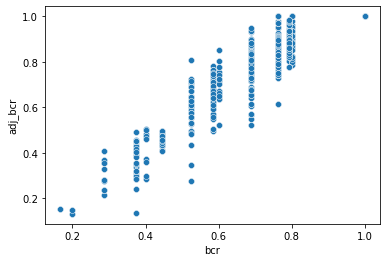

In [5]:
sns.scatterplot(x='bcr', y='adj_bcr', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='accuracy', ylabel='adj_accuracy'>

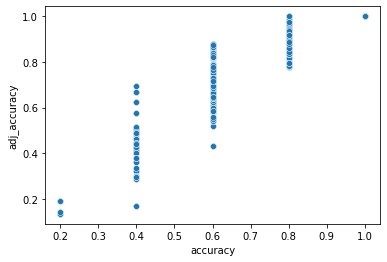

In [6]:
sns.scatterplot(x='accuracy', y='adj_accuracy', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='number', ylabel='adj_accuracy'>

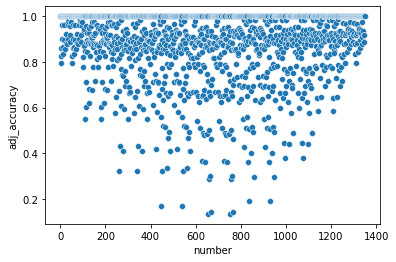

In [7]:
sns.scatterplot(x='number', y='adj_accuracy', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='number', ylabel='accuracy'>

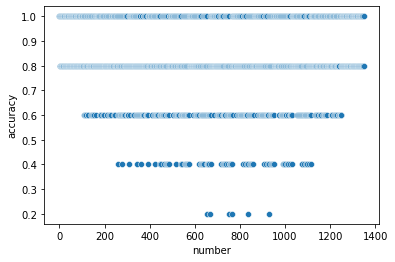

In [8]:
sns.scatterplot(x='number', y='accuracy', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='s_bcr', ylabel='s_adj_bcr'>

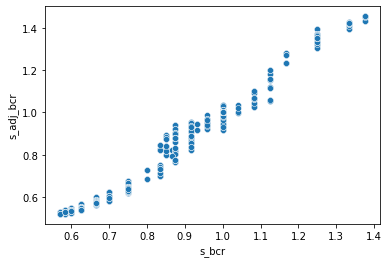

In [9]:
sns.scatterplot(x='s_bcr', y='s_adj_bcr', data=df, legend=False, palette = 'muted')

<AxesSubplot:xlabel='s_accuracy', ylabel='s_adj_accuracy'>

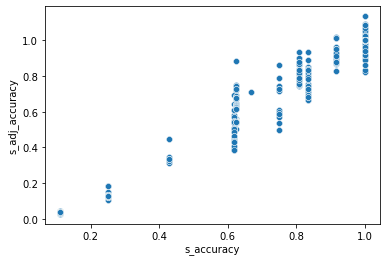

In [10]:
sns.scatterplot(x='s_accuracy', y='s_adj_accuracy', data=df, legend=False, palette = 'muted')

In [11]:
# how many clusters should be reserved for 5:5 groups
clustersNoMaj = round(len(df.query('minSize == majSize').index) / len(df.index) * params['clusters'])
# make sure the other clusters can be split for male and female majorities
if ((params['clusters'] - clustersNoMaj) % 2 == 1):
    clustersNoMaj += 1
clustersNoMaj

2

In [12]:
clustersMaj = params['clusters'] - clustersNoMaj
attributes = ['cv','adj_bcr','s_adj_bcr']

dfForClustering = df.copy()
scaler = StandardScaler()
dfForClustering[attributes] = scaler.fit_transform(dfForClustering[attributes])
imp = SimpleImputer(strategy='mean')
dfForClustering[attributes] = imp.fit_transform(dfForClustering[attributes])

dfFemale = dfForClustering.query("majLabel == 'female' and minSize != majSize")[attributes].copy()
clustering = AgglomerativeClustering(n_clusters = clustersMaj // 2, linkage='ward').fit(dfFemale)
dfFemale = df.query("majLabel == 'female' and minSize != majSize").copy()
dfFemale['cluster'] = clustering.labels_

dfMale = dfForClustering.query("majLabel == 'male' and minSize != majSize")[attributes].copy()
clustering2 = AgglomerativeClustering(n_clusters = clustersMaj // 2, linkage='ward').fit(dfMale)
dfMale = df.query("majLabel == 'male' and minSize != majSize").copy()
dfMale['cluster'] = clustering2.labels_ + clustersMaj // 2

dfTotal = dfFemale.append(dfMale)

dfNoMaj = dfForClustering.query("minSize == majSize")[attributes].copy()
clustering3 = AgglomerativeClustering(n_clusters = clustersNoMaj, linkage='ward').fit(dfNoMaj)
dfNoMaj = df.query("minSize == majSize").copy()
dfNoMaj['cluster'] = clustering3.labels_ + clustersMaj

dfClustered = dfTotal.append(dfNoMaj)
dfClustered

,questionType,showScores,groupNames,colors,number,minSize,majSize,majLabel,tpr,tnr,...,s_tpr,s_tnr,s_bcr,s_accuracy,s_adj_tpr,s_adj_tnr,s_adj_bcr,s_adj_accuracy,cv,cluster
49,selection,True,"[Männer, Frauen]","[teal, pink]",49,1,9,female,1.000000,1.000000,...,NaN,1.0,NaN,1.000000,NaN,1.0,NaN,1.000000,0.888889,1
50,selection,True,"[Männer, Frauen]","[teal, pink]",50,1,9,female,0.000000,0.888889,...,NaN,0.0,NaN,0.111111,NaN,0.0,NaN,0.042254,2.000000,0
51,selection,True,"[Männer, Frauen]","[teal, pink]",51,1,9,female,1.000000,1.000000,...,NaN,1.0,NaN,1.000000,NaN,1.0,NaN,1.000000,0.888889,1
52,selection,True,"[Männer, Frauen]","[teal, pink]",52,1,9,female,0.000000,0.888889,...,NaN,0.0,NaN,0.111111,NaN,0.0,NaN,0.042254,2.000000,0
53,selection,True,"[Männer, Frauen]","[teal, pink]",53,1,9,female,1.000000,1.000000,...,NaN,1.0,NaN,1.000000,NaN,1.0,NaN,1.000000,0.888889,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,selection,True,"[Männer, Frauen]","[teal, pink]",1345,5,5,female,0.888889,0.000000,...,0.8,NaN,NaN,1.000000,0.916031,NaN,NaN,1.000368,0.800000,8
1346,selection,True,"[Männer, Frauen]","[teal, pink]",1346,5,5,female,0.888889,0.000000,...,0.8,NaN,NaN,1.000000,0.880000,NaN,NaN,0.964337,0.800000,9
1347,selection,True,"[Männer, Frauen]","[teal, pink]",1347,5,5,female,1.000000,1.000000,...,1.0,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.200000,8
1348,selection,True,"[Männer, Frauen]","[teal, pink]",1348,5,5,female,0.888889,0.000000,...,0.8,NaN,NaN,1.000000,0.853774,NaN,NaN,0.938111,0.800000,9


<AxesSubplot:xlabel='adj_bcr', ylabel='cv'>

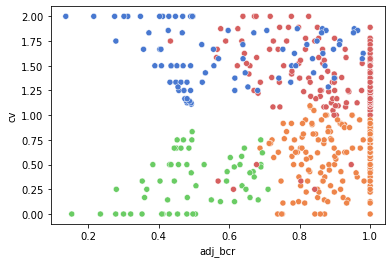

In [13]:
# clusters for majority female
sns.scatterplot(x='adj_bcr', y='cv', hue='cluster',
                data=dfClustered.query("majLabel == 'female' and majSize != minSize"),
                legend=False, palette = 'muted')

<AxesSubplot:xlabel='adj_bcr', ylabel='cv'>

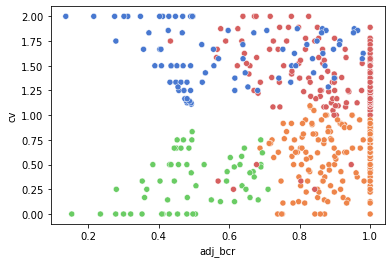

In [14]:
# clusters for majority male
sns.scatterplot(x='adj_bcr', y='cv', hue='cluster',
                data=dfClustered.query("majLabel == 'male' and majSize != minSize"),
                legend=False, palette = 'muted')

<AxesSubplot:xlabel='adj_bcr', ylabel='cv'>

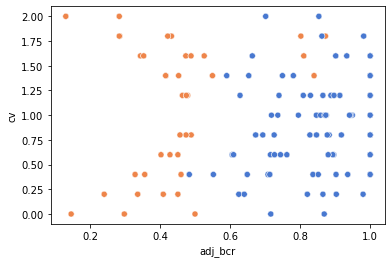

In [15]:
# clusters where there is no majority
sns.scatterplot(x='adj_bcr', y='cv', hue='cluster',
                data=dfClustered.query("majSize == minSize"),
                legend=False, palette = 'muted')

<AxesSubplot:xlabel='adj_bcr', ylabel='cv'>

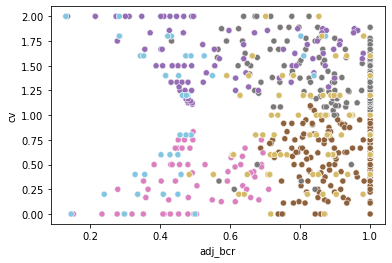

In [16]:
# all clusters
sns.scatterplot(x='adj_bcr', y='cv', hue='cluster', data=dfClustered, legend=False, palette = 'muted')

<AxesSubplot:xlabel='s_adj_bcr', ylabel='cv'>

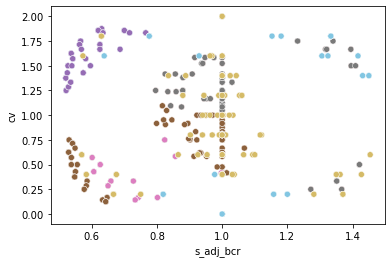

In [17]:
sns.scatterplot(x='s_adj_bcr', y='cv', hue='cluster', data=dfClustered, legend=False, palette = 'muted')

<AxesSubplot:xlabel='s_adj_bcr', ylabel='adj_bcr'>

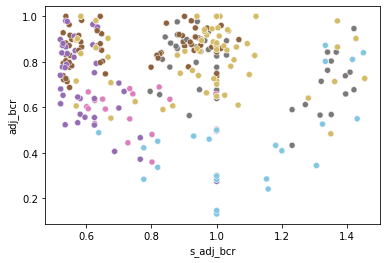

In [18]:
sns.scatterplot(x='s_adj_bcr', y='adj_bcr', hue='cluster', data=dfClustered, legend=False, palette = 'muted')

In [19]:
male = 0
female = 0
noMaj = 0
for i in range(len(questions)):
    if (questions[i]['majSize'] != questions[i]['minSize']):
        if (questions[i]['majLabel'] == 'female'):
            questions[i]['cluster'] = int(clustering.labels_[female])
            female += 1
        else:
            questions[i]['cluster'] = int(clustering2.labels_[male]) + clustersMaj // 2
            male += 1
    else:
        questions[i]['cluster'] = int(clustering3.labels_[noMaj]) + clustersMaj
        noMaj += 1
        
with open("selection_questions.json", "w") as write_file:
    json.dump(questions, write_file)

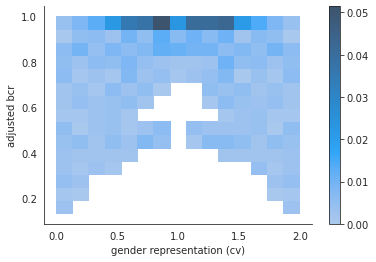

In [35]:
# add gender-focused version of the cv score (demographic parity)
# S=1 for male personas, S=0 for female personas
dfClustered['gender_cv'] = dfClustered['cv']
dfClustered.loc[df['majLabel']=='female', 'gender_cv'] = 2-dfClustered['cv']

sns.set_style("white")
ax = sns.histplot(data=dfClustered, x='gender_cv', y='adj_bcr', bins=15, cbar=True, stat='probability')
ax.set(ylabel='adjusted bcr', xlabel='gender representation (cv)')
sns.despine()